## Convert time series to image 
Based on https://gist.github.com/oguiza/c9c373aec07b96047d1ba484f23b7b47
and https://www.tensorflow.org/tutorials/load_data/images
and https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale

df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('sample_solution.csv')
Y = df_train['Label'].values

In [2]:
dataframes = np.load('allData.npy', allow_pickle = True)

def load_test_dataframe(id):
    test_data = np.load("test/test/{}.npy".format(id))
    return test_data


for i in range(len(dataframes)):
    dataframes[i] = minmax_scale(dataframes[i])

testdatas = []
for id in df_test['Id']:
    dfi = minmax_scale(load_test_dataframe(id))
    testdatas.append(dfi)

In [6]:
from pyts.multivariate.image import JointRecurrencePlot
from tqdm import tqdm

transformer = JointRecurrencePlot()
def convert_to_image(dfs):
    data = []
    for i in tqdm(range(len(dfs))):
        df = transformer.transform(dfs[i].reshape(1,dfs[i].shape[0],dfs[i].shape[1]))
        data.append(df)
    data = np.stack(data)
    return data

In [7]:
XTrain = convert_to_image(dataframes)

100%|█████████████████████████████████████████████████████████| 18662/18662 [1:10:56<00:00,  4.38it/s]


In [17]:
XTest = convert_to_image(testdatas)

100%|█████████████████████████████████████████████████████████████| 6051/6051 [09:23<00:00, 10.73it/s]


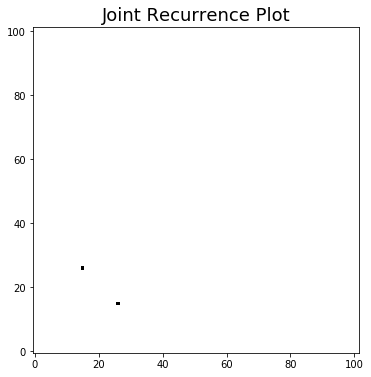

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(XTrain[0][0], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.show()

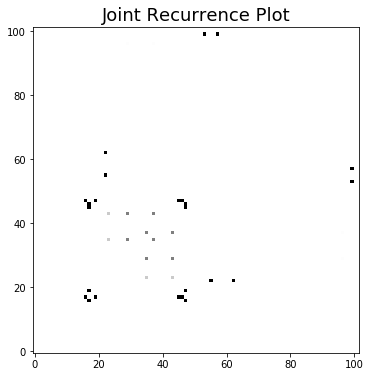

In [11]:
plt.figure(figsize=(6, 6))
plt.imshow(XTrain[1][0], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.show()

In [20]:
np.save('XTrain_image.npy', XTrain)

In [21]:
np.save('XTest_image.npy', XTest)

In [2]:
XTrain = np.load('XTrain_image.npy', allow_pickle = True)
XTest = np.load('XTest_image.npy', allow_pickle = True)

In [4]:
XTrain = XTrain.reshape((XTrain.shape[0], XTrain.shape[2], XTrain.shape[3]))
XTrain.shape

(18662, 102, 102)

In [5]:
XTest = XTest.reshape((XTest.shape[0], XTest.shape[2], XTest.shape[3]))
XTest.shape

(6051, 102, 102)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(XTrain, Y, test_size=0.2, random_state=42)

In [27]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def save_as_image(data, folder, y = []):
    y = np.array(y)
    for i in tqdm(range(data.shape[0])):
        img_id = str(i) + '.png'
        if y.shape[0] == data.shape[0]:
            class_dir = str(y[i])
            class_folder = folder + '/' + class_dir            
        else:
            class_folder = folder
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        img_dir = class_folder + '/' + img_id
        plt.figure(figsize=(8, 8))
        plt.imshow(data[i], cmap='binary', origin='lower')
        plt.title('Joint Recurrence Plot', fontsize=16)
        plt.savefig(img_dir, transparent=True)
        plt.close()

In [28]:
save_as_image(X_train, 'image/train', y_train)

100%|███████████████████████████████████████████████████████████| 14929/14929 [43:15<00:00,  5.75it/s]


In [29]:
save_as_image(X_val, 'image/valid', y_val)

100%|█████████████████████████████████████████████████████████████| 3733/3733 [10:21<00:00,  6.00it/s]


In [30]:
save_as_image(XTest, 'image/test')

100%|█████████████████████████████████████████████████████████████| 6051/6051 [16:12<00:00,  6.22it/s]


In [41]:
import tensorflow as tf
train_ds = tf.data.Dataset.list_files(str('image/train/*'))
valid_ds = tf.data.Dataset.list_files(str('image/valid/*'))
test_ds = tf.data.Dataset.list_files(str('image/test/*'))

In [42]:
for f in train_ds.take(5):
  print(f.numpy())

b'image\\train\\0\\2120.png'
b'image\\train\\0\\10201.png'
b'image\\train\\1\\3566.png'
b'image\\train\\1\\5001.png'
b'image\\train\\1\\7722.png'


In [75]:
CLASS_NAMES = ['0','1']

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '\\')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path_image(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = process_path_image(file_path)
    return img, label

In [76]:
get_label('image\\train\\0\\2120.png')

<tf.Tensor: id=1055, shape=(2,), dtype=bool, numpy=array([ True, False])>

In [77]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test_ds = test_ds.map(process_path_image, num_parallel_calls=AUTOTUNE)

In [78]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = labeled_train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = labeled_valid_ds.batch(BATCH_SIZE)
test_batches = labeled_test_ds.batch(BATCH_SIZE)

In [79]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 576, 576, 3])

In [80]:
IMG_SIZE = image_batch.shape[1]

In [81]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - ETA: 5: - ETA: 4: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 55s - ETA: 54 - ETA: 53 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 

In [86]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 576, 576, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 577, 577, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 288, 288, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 288, 288, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 72, 72, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 72, 72, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 72, 72, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 72, 72, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 72, 72, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 36, 36, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 36, 36, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 36, 36, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 36, 36, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 36, 36, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 36, 36, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 37, 37, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 18, 18, 576)  5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 18, 18, 576)  2304        block_13_depthwise[0][0]         
__________

In [82]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 18, 18, 1280)


In [83]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [99]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


## Fine Tuning

In [88]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [100]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
]

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=METRICS)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 18, 18, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [101]:
len(model.trainable_variables)

58

In [102]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [ ]:
EPOCHS = 100
baseline_history = model.fit(
        train_batches,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        validation_data=validation_batches)

Epoch 1/100
     12/Unknown - 41s 41s/step - loss: 0.8197 - accuracy: 0.4375 - auc: 0.42 - 81s 40s/step - loss: 0.7096 - accuracy: 0.6094 - auc: 0.55 - 116s 39s/step - loss: 0.6777 - accuracy: 0.6458 - auc: 0.605 - 150s 37s/step - loss: 0.6427 - accuracy: 0.6719 - auc: 0.674 - 185s 37s/step - loss: 0.6431 - accuracy: 0.6687 - auc: 0.675 - 221s 37s/step - loss: 0.6601 - accuracy: 0.6458 - auc: 0.647 - 256s 37s/step - loss: 0.6619 - accuracy: 0.6384 - auc: 0.644 - 291s 36s/step - loss: 0.6494 - accuracy: 0.6719 - auc: 0.665 - 325s 36s/step - loss: 0.6429 - accuracy: 0.6806 - auc: 0.676 - 361s 36s/step - loss: 0.6444 - accuracy: 0.6719 - auc: 0.674 - 396s 36s/step - loss: 0.6381 - accuracy: 0.6818 - auc: 0.687 - 431s 36s/step - loss: 0.6356 - accuracy: 0.6875 - auc: 0.6920

In [ ]:
YTest = model.predict(XTest)
df_test['Predicted'] = YTest[:, 0]
df_test

In [ ]:
df_test.to_csv('test.csv', index=False)